<a href="https://www.kaggle.com/code/hongtptrai/big-data?scriptVersionId=288926482" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**Library and Initial Enviroment**

In [1]:
import shutil
import subprocess
import os
import sys
import io
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import time
from PIL import Image
from torchvision.transforms import Compose
from pyspark.sql.functions import col 
from pyspark.sql import SparkSession
from pyspark import TaskContext

print("=== BẮT ĐẦU SETUP ===")

# --- 1. CLONE REPO ---
repo_dir = "/kaggle/working/Depth-Aware-Editing"

# Kiểm tra folder chưa có hoặc rỗng thì mới clone
should_clone = False
if not os.path.exists(repo_dir):
    should_clone = True
elif not os.listdir(repo_dir):
    should_clone = True

if should_clone:
    print("1. Đang Clone Repo 'Depth-Aware-Editing'...")
    subprocess.run(["git", "clone", "https://github.com/rishubhpar/Depth-Aware-Editing", repo_dir])
else:
    print("1. Repo chính đã có và không rỗng.")

# --- 2. SETUP DINOv2 ---
hub_dir = "/kaggle/working/torchhub"
dinov2_path = os.path.join(hub_dir, "facebookresearch_dinov2_main")

if not os.path.exists(dinov2_path):
    print("2. Đang cài đặt DINOv2...")
    os.makedirs(hub_dir, exist_ok=True)
    subprocess.run(["wget", "-q", "-O", "dinov2.zip", "https://github.com/facebookresearch/dinov2/archive/refs/heads/main.zip"])
    subprocess.run(["unzip", "-q", "-o", "dinov2.zip", "-d", hub_dir])
    
    extracted_path = os.path.join(hub_dir, "dinov2-main")
    if os.path.exists(extracted_path):
        if os.path.exists(dinov2_path):
            shutil.rmtree(dinov2_path)
        os.rename(extracted_path, dinov2_path)
    
    if os.path.exists("dinov2.zip"):
        os.remove("dinov2.zip")
    print("   -> DINOv2 Ready.")
else:
    print("2. DINOv2 đã có sẵn.")

# --- 3. TẢI WEIGHTS ---
weights_dir = os.path.join(repo_dir, "weights")
os.makedirs(weights_dir, exist_ok=True)
weights_path = os.path.join(weights_dir, "depth_anything_vits14.pth")
url = "https://huggingface.co/spaces/LiheYoung/Depth-Anything/resolve/main/checkpoints/depth_anything_vits14.pth"

# Xóa file lỗi (<1MB)
if os.path.exists(weights_path):
    if os.path.getsize(weights_path) < 1_000_000:
        os.remove(weights_path)

if not os.path.exists(weights_path):
    print("3. Đang tải Weights (VITS)...")
    subprocess.run(["curl", "-L", "-o", weights_path, url])

# Kiểm tra kết quả
if os.path.exists(weights_path) and os.path.getsize(weights_path) > 1_000_000:
    sz = os.path.getsize(weights_path) / (1024 * 1024)
    print(f"✅ SETUP HOÀN TẤT! Weights: {sz:.2f} MB")
else:
    print("❌ Lỗi tải Weights. Hãy kiểm tra Internet!")

=== BẮT ĐẦU SETUP ===
1. Đang Clone Repo 'Depth-Aware-Editing'...


Cloning into '/kaggle/working/Depth-Aware-Editing'...


2. Đang cài đặt DINOv2...
   -> DINOv2 Ready.
3. Đang tải Weights (VITS)...


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1335  100  1335    0     0   7160      0 --:--:-- --:--:-- --:--:--  7177
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

✅ SETUP HOÀN TẤT! Weights: 94.62 MB


100 94.6M  100 94.6M    0     0   130M      0 --:--:-- --:--:-- --:--:--  182M


In [2]:
CONFIG = {
    "REPO_PATH": "/kaggle/working/Depth-Aware-Editing/src/Depth-Anything",
    
    "INPUT_DATA_PATH": "/kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_train/*", 
    
    "OUTPUT_DATA_PATH": "/kaggle/working/depth_output",
}

if not os.path.exists(CONFIG["OUTPUT_DATA_PATH"]):
    os.makedirs(CONFIG["OUTPUT_DATA_PATH"])

**Core Logic**

In [3]:
def process_partition(iterator):
    import shutil
    import subprocess
    import os
    import sys
    import io
    import torch
    import torch.nn.functional as F
    import numpy as np
    import cv2
    import time
    from PIL import Image
    from torchvision.transforms import Compose
    from pyspark.sql.functions import col 
    from pyspark.sql import SparkSession
    from pyspark import TaskContext
    import random

    
    # --- 1. DESYNC: Ngủ ngẫu nhiên để tránh khởi động cùng lúc ---
    time.sleep(random.uniform(0.5, 3.0))
    
    # Setup Path
    repo_path = "/kaggle/working/Depth-Aware-Editing/src/Depth-Anything"
    if repo_path not in sys.path: sys.path.append(repo_path)
    
    try:
        from depth_anything.dpt import DepthAnything
        from depth_anything.util.transform import Resize, NormalizeImage, PrepareForNet
    except:
        sys.path.append("/kaggle/working/Depth-Aware-Editing/Depth-Anything")
        from depth_anything.dpt import DepthAnything
        from depth_anything.util.transform import Resize, NormalizeImage, PrepareForNet

    # Chọn GPU
    ctx = TaskContext.get()
    part_id = ctx.partitionId()
    
    if torch.cuda.is_available():
        gpu_id = part_id % torch.cuda.device_count()
        device = torch.device(f"cuda:{gpu_id}")
    else:
        device = torch.device("cpu")

    # --- 2. RETRY LOGIC: Thử khởi tạo model tối đa 3 lần ---
    depth_model = None
    config = { "encoder": "vits", "features": 64, "out_channels": [48, 96, 192, 384], "use_bn": False, "use_clstoken": False }
    
    for attempt in range(3):
        try:
            # Xóa cache cũ trước khi thử
            torch.cuda.empty_cache()
            
            # Khởi tạo model (Cách chuẩn)
            model = DepthAnything(config)
            
            # Đẩy vào GPU (Đây là bước hay lỗi nhất)
            depth_model = model.to(device).eval()
            
            # Nếu thành công thì thoát vòng lặp
            break 
        except RuntimeError as e:
            if "busy" in str(e) or "unavailable" in str(e):
                # Nếu GPU bận, chờ 3-5s rồi thử lại
                time.sleep(3 + random.random())
                continue
            else:
                # Nếu lỗi khác thì báo luôn
                return iter([(f"Init_Error_Part_{part_id}", str(e))])
        except Exception as e:
             return iter([(f"Init_Error_Part_{part_id}", str(e))])

    if depth_model is None:
        return iter([(f"GPU_Busy_Part_{part_id}", "Failed to load model after 3 attempts")])

    # Load Weights
    ckpt = "/kaggle/working/Depth-Aware-Editing/weights/depth_anything_vits14.pth"
    if os.path.exists(ckpt):
        depth_model.load_state_dict(torch.load(ckpt, map_location=device), strict=False)

    # Transform
    transform = Compose([
        Resize(width=518, height=518, resize_target=False, keep_aspect_ratio=True, ensure_multiple_of=14, resize_method='lower_bound', image_interpolation_method=cv2.INTER_CUBIC),
        NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        PrepareForNet(),
    ])
    
    out_dir = "/kaggle/working/depth_output"
    os.makedirs(out_dir, exist_ok=True)
    results = []
    
    # Batch Processing
    BATCH_SIZE = 16
    batch_data, batch_paths, batch_shapes = [], [], []

    def flush_batch():
        if not batch_data: return
        try:
            tensor = torch.from_numpy(np.concatenate(batch_data, axis=0)).to(device)
            with torch.no_grad(): preds = depth_model(tensor)
            
            for i, depth in enumerate(preds):
                h, w = batch_shapes[i]
                d_res = F.interpolate(depth[None, None], (h, w), mode='bilinear', align_corners=False)[0, 0]
                d_np = d_res.cpu().numpy()
                d_norm = (d_np - d_np.min()) / (d_np.max() - d_np.min()) * 255.0
                
                fname = os.path.basename(batch_paths[i]).replace(".jpg", ".png").replace(".png", ".png")
                Image.fromarray(d_norm.astype(np.uint8)).save(os.path.join(out_dir, fname))
                results.append((batch_paths[i], "Success"))
        except Exception as e:
            for p in batch_paths: results.append((p, str(e)))

    for row in iterator:
        try:
            img = Image.open(io.BytesIO(row.content)).convert("RGB")
            np_img = np.array(img) / 255.0
            batch_shapes.append(np_img.shape[:2])
            batch_data.append(transform({'image': np_img})['image'][None])
            batch_paths.append(row.path)
            
            if len(batch_data) >= BATCH_SIZE:
                flush_batch()
                batch_data, batch_paths, batch_shapes = [], [], []
        except: pass
        
    flush_batch()
    return iter(results)

**MapReduce**

In [4]:
def run_job():    
    # Tắt session cũ để giải phóng GPU
    try: SparkSession.getActiveSession().stop()
    except: pass

    # Khởi tạo Spark
    spark = SparkSession.builder \
        .master("local[2]") \
        .appName("Depth_Final_Stable") \
        .config("spark.driver.memory", "4g") \
        .config("spark.executor.memory", "4g") \
        .config("spark.driver.maxResultSize", "2g") \
        .getOrCreate()

    print(">> Đang đọc dữ liệu...")
    CONFIG_INPUT = "/kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_train/*"
    
    df = spark.read.format("binaryFile") \
        .option("recursiveFileLookup", "true") \
        .load(CONFIG_INPUT) \
        .filter(col("path").rlike("(?i).*\\.jpg$"))

    # Dùng 40 partitions để cân bằng tải
    NUM_PARTITIONS = 40
    print(f">> ⚡ REPARTITION: {NUM_PARTITIONS} Tasks")
    
    count = df.repartition(NUM_PARTITIONS).rdd.mapPartitions(process_partition).count()
    print(f">> ✅ XONG! Đã xử lý: {count} ảnh.")
    spark.stop()

if __name__ == "__main__":
    run_job()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/28 17:47:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


>> Đang đọc dữ liệu...


>> ⚡ REPARTITION: 40 Tasks


/kaggle/working/torchhub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/kaggle/working/torchhub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/kaggle/working/torchhub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
/kaggle/working/torchhub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/kaggle/working/torchhub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/kaggle/working/torchhub/facebookresearch_dinov2_main/din

>> ✅ XONG! Đã xử lý: 50688 ảnh.


**Result**

✅ Tìm thấy 732 ảnh kết quả.


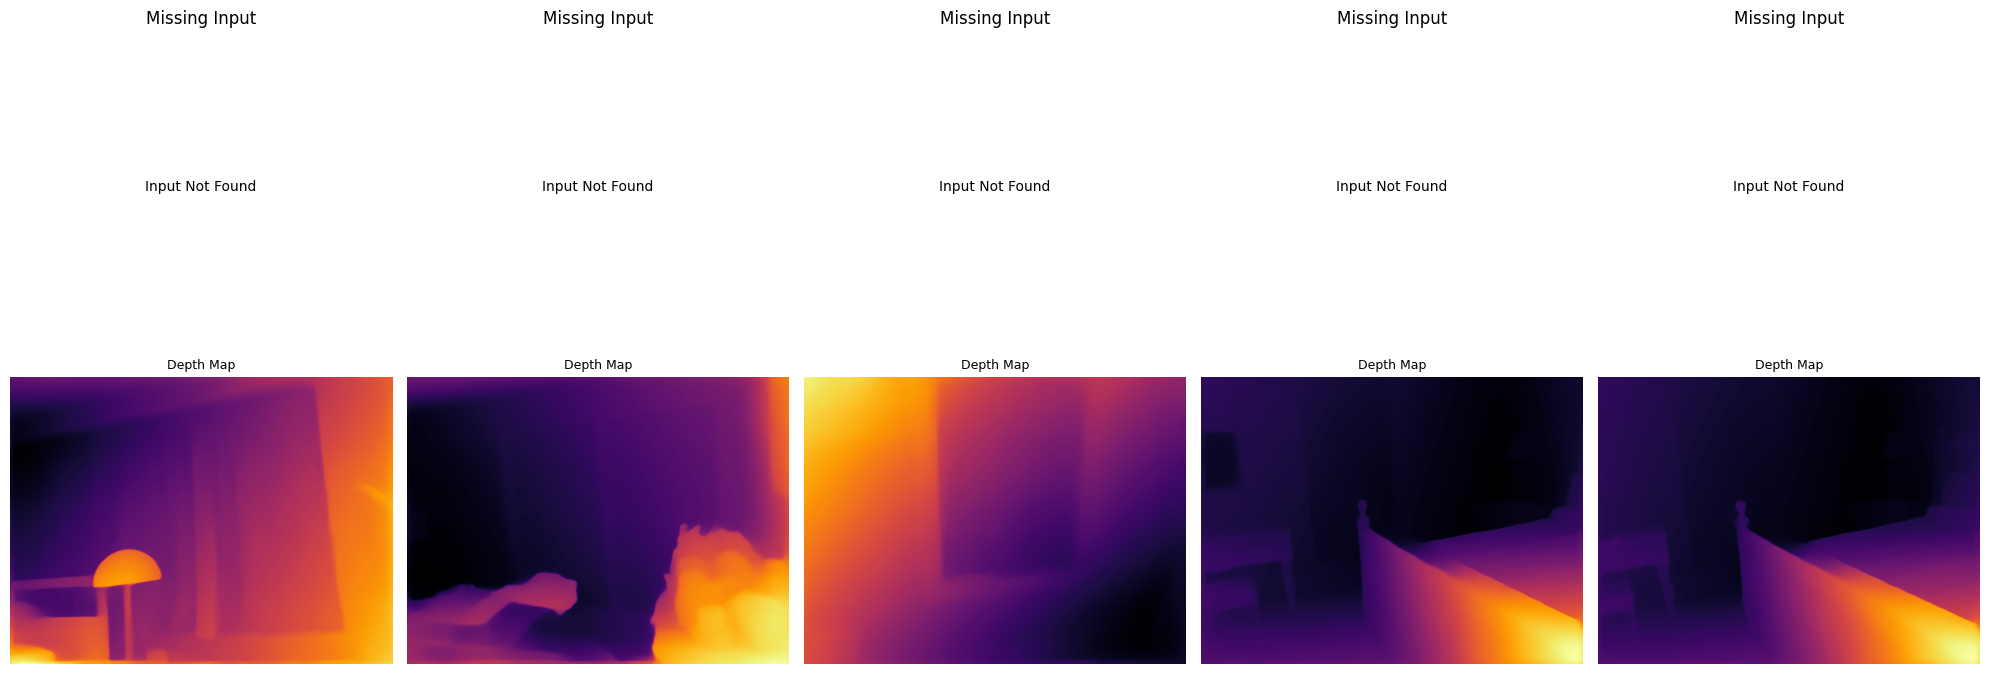

In [5]:
import matplotlib.pyplot as plt
import glob
from PIL import Image
import os

# 1. Cấu hình đường dẫn
output_dir = "/kaggle/working/depth_output"
# Đường dẫn folder chứa ảnh gốc (Dựa trên config input ở cell trên)
input_dir = "/kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_train"

# 2. Lấy danh sách ảnh kết quả
output_paths = sorted(glob.glob(os.path.join(output_dir, "*.png")))

if not output_paths:
    print("❌ Không tìm thấy ảnh nào trong folder output!")
else:
    print(f"✅ Tìm thấy {len(output_paths)} ảnh kết quả.")
    
    # Số lượng ảnh cần show (max 5)
    num_show = min(5, len(output_paths))
    
    # Tạo khung hình: 2 hàng (Input - Output) x num_show cột
    fig, axes = plt.subplots(2, num_show, figsize=(4 * num_show, 7))
    
    # Xử lý trường hợp chỉ có 1 ảnh (axes không phải mảng 2 chiều)
    if num_show == 1:
        axes = axes.reshape(2, 1)

    for i in range(num_show):
        # --- XỬ LÝ ẢNH OUTPUT (DEPTH) ---
        out_path = output_paths[i]
        out_img = Image.open(out_path)
        filename = os.path.basename(out_path) # vd: hinh_anh.png
        basename = os.path.splitext(filename)[0] # vd: hinh_anh
        
        # --- TÌM ẢNH INPUT TƯƠNG ỨNG ---
        # Thử tìm file .jpg trước, nếu không có thì tìm .png
        in_path = os.path.join(input_dir, basename + ".jpg")
        if not os.path.exists(in_path):
            in_path = os.path.join(input_dir, basename + ".png")
            
        # --- HIỂN THỊ ---
        # 1. Hàng trên: Ảnh gốc (Input)
        if os.path.exists(in_path):
            in_img = Image.open(in_path)
            axes[0, i].imshow(in_img)
            axes[0, i].set_title(f"Input\n{filename}", fontsize=9)
        else:
            axes[0, i].text(0.5, 0.5, "Input Not Found", ha='center')
            axes[0, i].set_title("Missing Input")
        axes[0, i].axis('off')

        # 2. Hàng dưới: Ảnh độ sâu (Output)
        axes[1, i].imshow(out_img, cmap='inferno') # Dùng colormap 'inferno' cho đẹp
        axes[1, i].set_title("Depth Map", fontsize=9)
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()